In [5]:
%reset

In [7]:
import numpy as np
import matplotlib.pyplot as plt

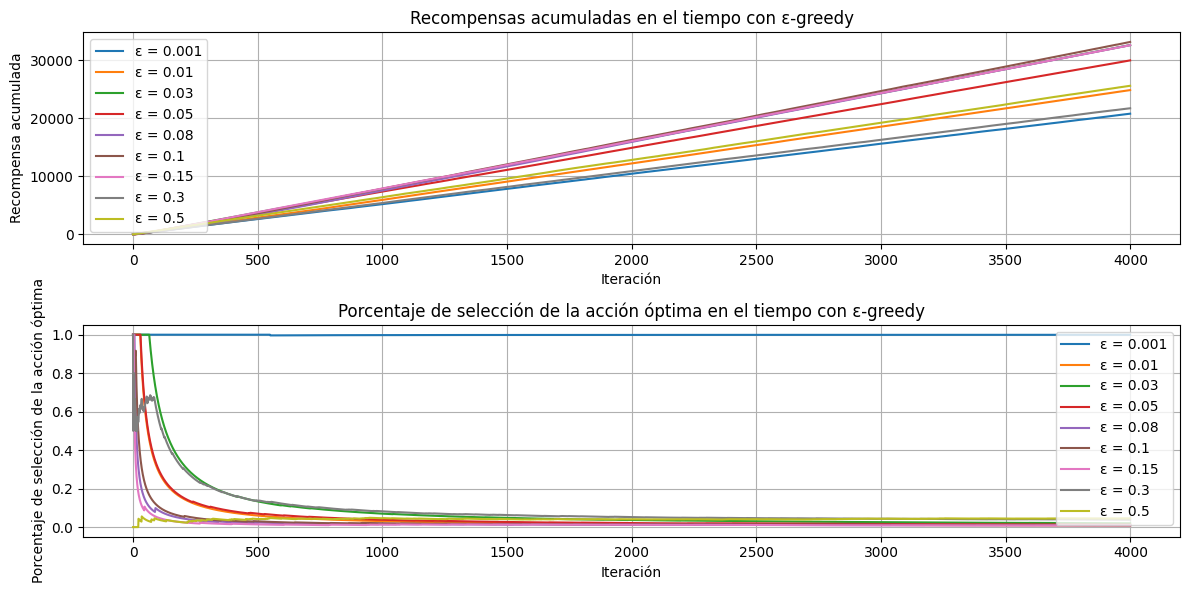

In [16]:
class BanditTestbed:
    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.q_estimated = 0
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.q_estimated = self.total_rewards / self.action_counts[action]
        self.rewards_history.append(reward)
        if action == np.argmax(self.q_estimated):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                action = np.argmax(self.action_values / (self.action_counts + 1e-5)) # Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
            self.pullArm(action, varianceActions)                                    # división tienda a infinito cuando el número de acciones tomadas es 0.
            rewards.append(self.total_rewards)
        return rewards, self.optimal_action_percentage_history



def run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history



def plot_results(epsilon_values, rewards_history, optimal_action_percentage_history):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa acumulada')
    plt.title('Recompensas acumuladas en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.subplot(2, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)

In [ ]:
class BanditTestbed:
    def __init__(self, num_bandits, mean, varianceInitBandits):
        self.bandits_mean_values = np.random.normal(mean, np.sqrt(varianceInitBandits), size=num_bandits)
        self.action_values = np.zeros(num_bandits)
        self.action_counts = np.zeros(num_bandits)
        self.total_rewards = 0
        self.optimal_action_count = 0
        self.rewards_history = []
        self.optimal_action_percentage_history = []

    def pullArm(self, action, varianceActions):
        reward = np.random.normal(self.bandits_mean_values[action], varianceActions)
        self.action_values[action] += reward
        self.action_counts[action] += 1
        self.total_rewards += reward
        self.rewards_history.append(reward)
        if action == np.argmax(self.action_values):
            self.optimal_action_count += 1
        self.optimal_action_percentage_history.append(self.optimal_action_count / sum(self.action_counts))

    def epsilon_greedy(self, epsilon, num_iterations, varianceActions):
        rewards = []
        for i in range(num_iterations):
            rand_num = np.random.rand()
            if rand_num < epsilon:
                action = np.random.choice(num_bandits)
            else:
                action = np.argmax(self.action_values / (self.action_counts + 1e-5)) # Cabe resaltar que el valor de 1e-5 se introduce para evitar que la
            self.pullArm(action, varianceActions)                                    # división tienda a infinito cuando el número de acciones tomadas es 0.
            rewards.append(self.total_rewards)
        return rewards, self.optimal_action_percentage_history



def run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits):
    rewards_history = []
    optimal_action_percentage_history = []
    for epsilon in epsilon_values:
        testbed = BanditTestbed(num_bandits, mean, varianceInitBandits)
        rewards, optimal_action_percentage = testbed.epsilon_greedy(epsilon, num_iterations, varianceActions)
        rewards_history.append(rewards)
        optimal_action_percentage_history.append(optimal_action_percentage)
    return rewards_history, optimal_action_percentage_history



def plot_results(epsilon_values, rewards_history, optimal_action_percentage_history):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(rewards_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Recompensa acumulada')
    plt.title('Recompensas acumuladas en el tiempo con ε-greedy')
    plt.legend()

    plt.subplot(2, 1, 2)
    for i, epsilon in enumerate(epsilon_values):
        plt.plot(optimal_action_percentage_history[i], label=f'ε = {epsilon}')
    plt.xlabel('Iteración')
    plt.ylabel('Porcentaje de selección de la acción óptima')
    plt.title('Porcentaje de selección de la acción óptima en el tiempo con ε-greedy')
    plt.legend()

    plt.tight_layout()
    plt.show()

num_bandits = 12
mean = 5
varianceInitBandits = 3
varianceActions = 1
num_iterations = 4000
epsilon_values = [0.001, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.3, 0.5]

rewards_history, optimal_action_percentage_history = run_experiment(num_bandits, num_iterations, epsilon_values, varianceActions, mean, varianceInitBandits)
plot_results(epsilon_values, rewards_history, optimal_action_percentage_history)